# Evaluation of stock prediction model

## Part 0: Setup

In [120]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, time
from termcolor import colored

from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# Dependencies for the LSTM model
from sklearn.preprocessing import MinMaxScaler
%pip install --upgrade tensorflow
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError as mse
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from tensorflow import keras
from keras.utils import pad_sequences
%pip install gputil
import GPUtil as GPU
from IPython.display import clear_output
clear_output()

## Part 1: Load the previously trained model.

In [121]:
MODEL_PATH = "./data/stock_prediction.h5"
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

# Show model details
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,513 (119.19 KB)

 Trainable params: 30,321 (118.44 KB)

 Non-trainable params: 192 (768.00 B)

## Part 2: Create Test Cases

Here we list some variables for the test stocks. We've downloaded the for one past year from the NASDAQ site. There are some formatting specific things, that we will fix in the following code.

In [122]:
TESTDATADIR = "./data/test_stocks/"
TESTSTOCKS = [
    "AAPL", # Apple
    "AMD",  # AMD
    "AMZN", # Amazon
    "META", # Meta Platforms
    "NFLX", # Netflix
    "QCOM", # Qualcomm
    "SBUX", # Starbucks
    "SCSO", # Cisco
    "TSLA", # Tesla
]

In [123]:
# Create a dictionary to hold the test data for each stock
test_data = {}
for stock in TESTSTOCKS:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(f"{TESTDATADIR}{stock}.csv")
    
    # The data column is given in the format "MM/DD/YYYY", change that to datetime
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
    
    # Remove the dollar sign from the columns where the value is monetary
    monetary_columns = ['Close/Last', 'Open', 'High', 'Low']
    for col in monetary_columns:
        df[col] = df[col].replace({'\$': '', ',': ''}, regex=True).astype(float)
        
    # Drop the columns not in Date and Close/Last
    df = df[['Date', 'Close/Last']]
    
    # Rename the columns to 'Date' and 'Close'
    df.columns = ['Date', 'Close']
        
    # Add the stock to the data dictionary
    test_data[stock] = df

<>:13: SyntaxWarning: invalid escape sequence '\$'
<>:13: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_27534/930247336.py:13: SyntaxWarning: invalid escape sequence '\$'
  df[col] = df[col].replace({'\$': '', ',': ''}, regex=True).astype(float)


In [124]:
# Scale the closing prices for each stock and store the scaler and df in a tuple.
for stock, df in test_data.items():
    # Create a MinMaxScaler object
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Fit the scaler to the closing prices
    df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
    
    # Store the scaler and df in a tuple
    test_data[stock] = (scaler, df)

In [125]:
# Create X_test and y_test for each stock
for stock, (scaler, df) in test_data.items():
    # Data is the closing prices
    data = df['Close'].values
    
    # Preprocess the data
    X_test = []
    y_test = []
    for i in range(30, len(data)):
        X_test.append(data[i-30:i])
        y_test.append(data[i])
        
    # Turn these data to numpy format, reshape, and return.
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Save the data as (df, X_test, y_test, scaler)
    test_data[stock] = (df, X_test, y_test, scaler)
        
    # Print final details
    print(f"Final data for the stock '{stock}'...")
    print(f"   Shape of X_test: {X_test.shape}")
    print(f"   Shape of y_test: {y_test.shape}")
    print()

Final data for the stock 'AAPL'...
   Shape of X_test: (220, 30, 1)
   Shape of y_test: (220,)

Final data for the stock 'AMD'...
   Shape of X_test: (220, 30, 1)
   Shape of y_test: (220,)

Final data for the stock 'AMZN'...
   Shape of X_test: (220, 30, 1)
   Shape of y_test: (220,)

Final data for the stock 'META'...
   Shape of X_test: (220, 30, 1)
   Shape of y_test: (220,)

Final data for the stock 'NFLX'...
   Shape of X_test: (220, 30, 1)
   Shape of y_test: (220,)

Final data for the stock 'QCOM'...
   Shape of X_test: (220, 30, 1)
   Shape of y_test: (220,)

Final data for the stock 'SBUX'...
   Shape of X_test: (220, 30, 1)
   Shape of y_test: (220,)

Final data for the stock 'SCSO'...
   Shape of X_test: (220, 30, 1)
   Shape of y_test: (220,)

Final data for the stock 'TSLA'...
   Shape of X_test: (220, 30, 1)
   Shape of y_test: (220,)



## Part 3: Predicting with the model

### Part 3.1: Make predictions with the test data.

In [126]:
def predict_stock_price(model, ticker_data):
    """
    Predicts the stock price using the trained model.
    The input data should be a 3D array of shape (n_samples, 30, 1).
    The input data should be preprocessed in the same way as the training data. (normalized, reshaped)
    """
    # Get the input test data.
    X_test, y_test, scaler = ticker_data
    
    # Assert the input data shape
    expected_shape = (None, 30, 1)
    assert len(X_test.shape) == 3, f"Expected 3D array, got {len(X_test.shape)}D array"
    assert X_test.shape[1] == 30, f"Expected 30 time steps, got {X_test.shape[1]} time steps"
    assert X_test.shape[2] == 1, f"Expected 1 feature, got {X_test.shape[2]} features"
    
    # Make predictions
    predictions = model.predict(X_test)
    return predictions

In [127]:
# Now that cases are created, as (dataframe, X_test, y_test, scaler) for each ticker, we can predict the stock prices
for ticker, (dataframe, X_test, y_test, scaler) in test_data.items():
    # Predict the stock price
    predictions = predict_stock_price(model, (X_test, y_test, scaler))
    
    # Inverse transform the predictions and y_test to get the actual prices
    predictions_unscaled = scaler.inverse_transform(predictions)
    y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Create a DataFrame to hold the results
    results = pd.DataFrame({
        'Date': dataframe['Date'][30:],
        'Actual_Scaled': y_test,
        'Prediction_Scaled': predictions.flatten(),
        'Actual': y_test_unscaled.flatten(),
        'Prediction': predictions_unscaled.flatten()
    })
    
    # Update the test_data dictionary with the results
    test_data[ticker] = (dataframe, X_test, y_test, scaler, results)
    
    # Print the first few rows of the results
    print(f"Results for {ticker}:")
    print(results.head())

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Results for AAPL:
         Date  Actual_Scaled  Prediction_Scaled  Actual  Prediction
30 2025-03-25       0.592725           0.532328  223.75  218.519653
31 2025-03-24       0.557852           0.553596  220.73  220.361404
32 2025-03-21       0.529446           0.521709  218.27  217.599976
33 2025-03-20       0.481293           0.500552  214.10  215.767776
34 2025-03-19       0.494457           0.464448  215.24  212.641190
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Results for AMD:
         Date  Actual_Scaled  Prediction_Scaled  Actual  Prediction
30 2025-03-25       0.346099           0.330493  114.81  113.159599
31 2025-03-24       0.337021           0.366514  113.85  116.968895
32 2025-03-21       0.266950           0.338845  106.44  114.042831
33 2025-03-20       0.273570           0.273765  107.14  107.160606
34 2025-03-19       0.264965           0.286258  106.23  108.481804
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Results for AMZN:
         Date  Ac

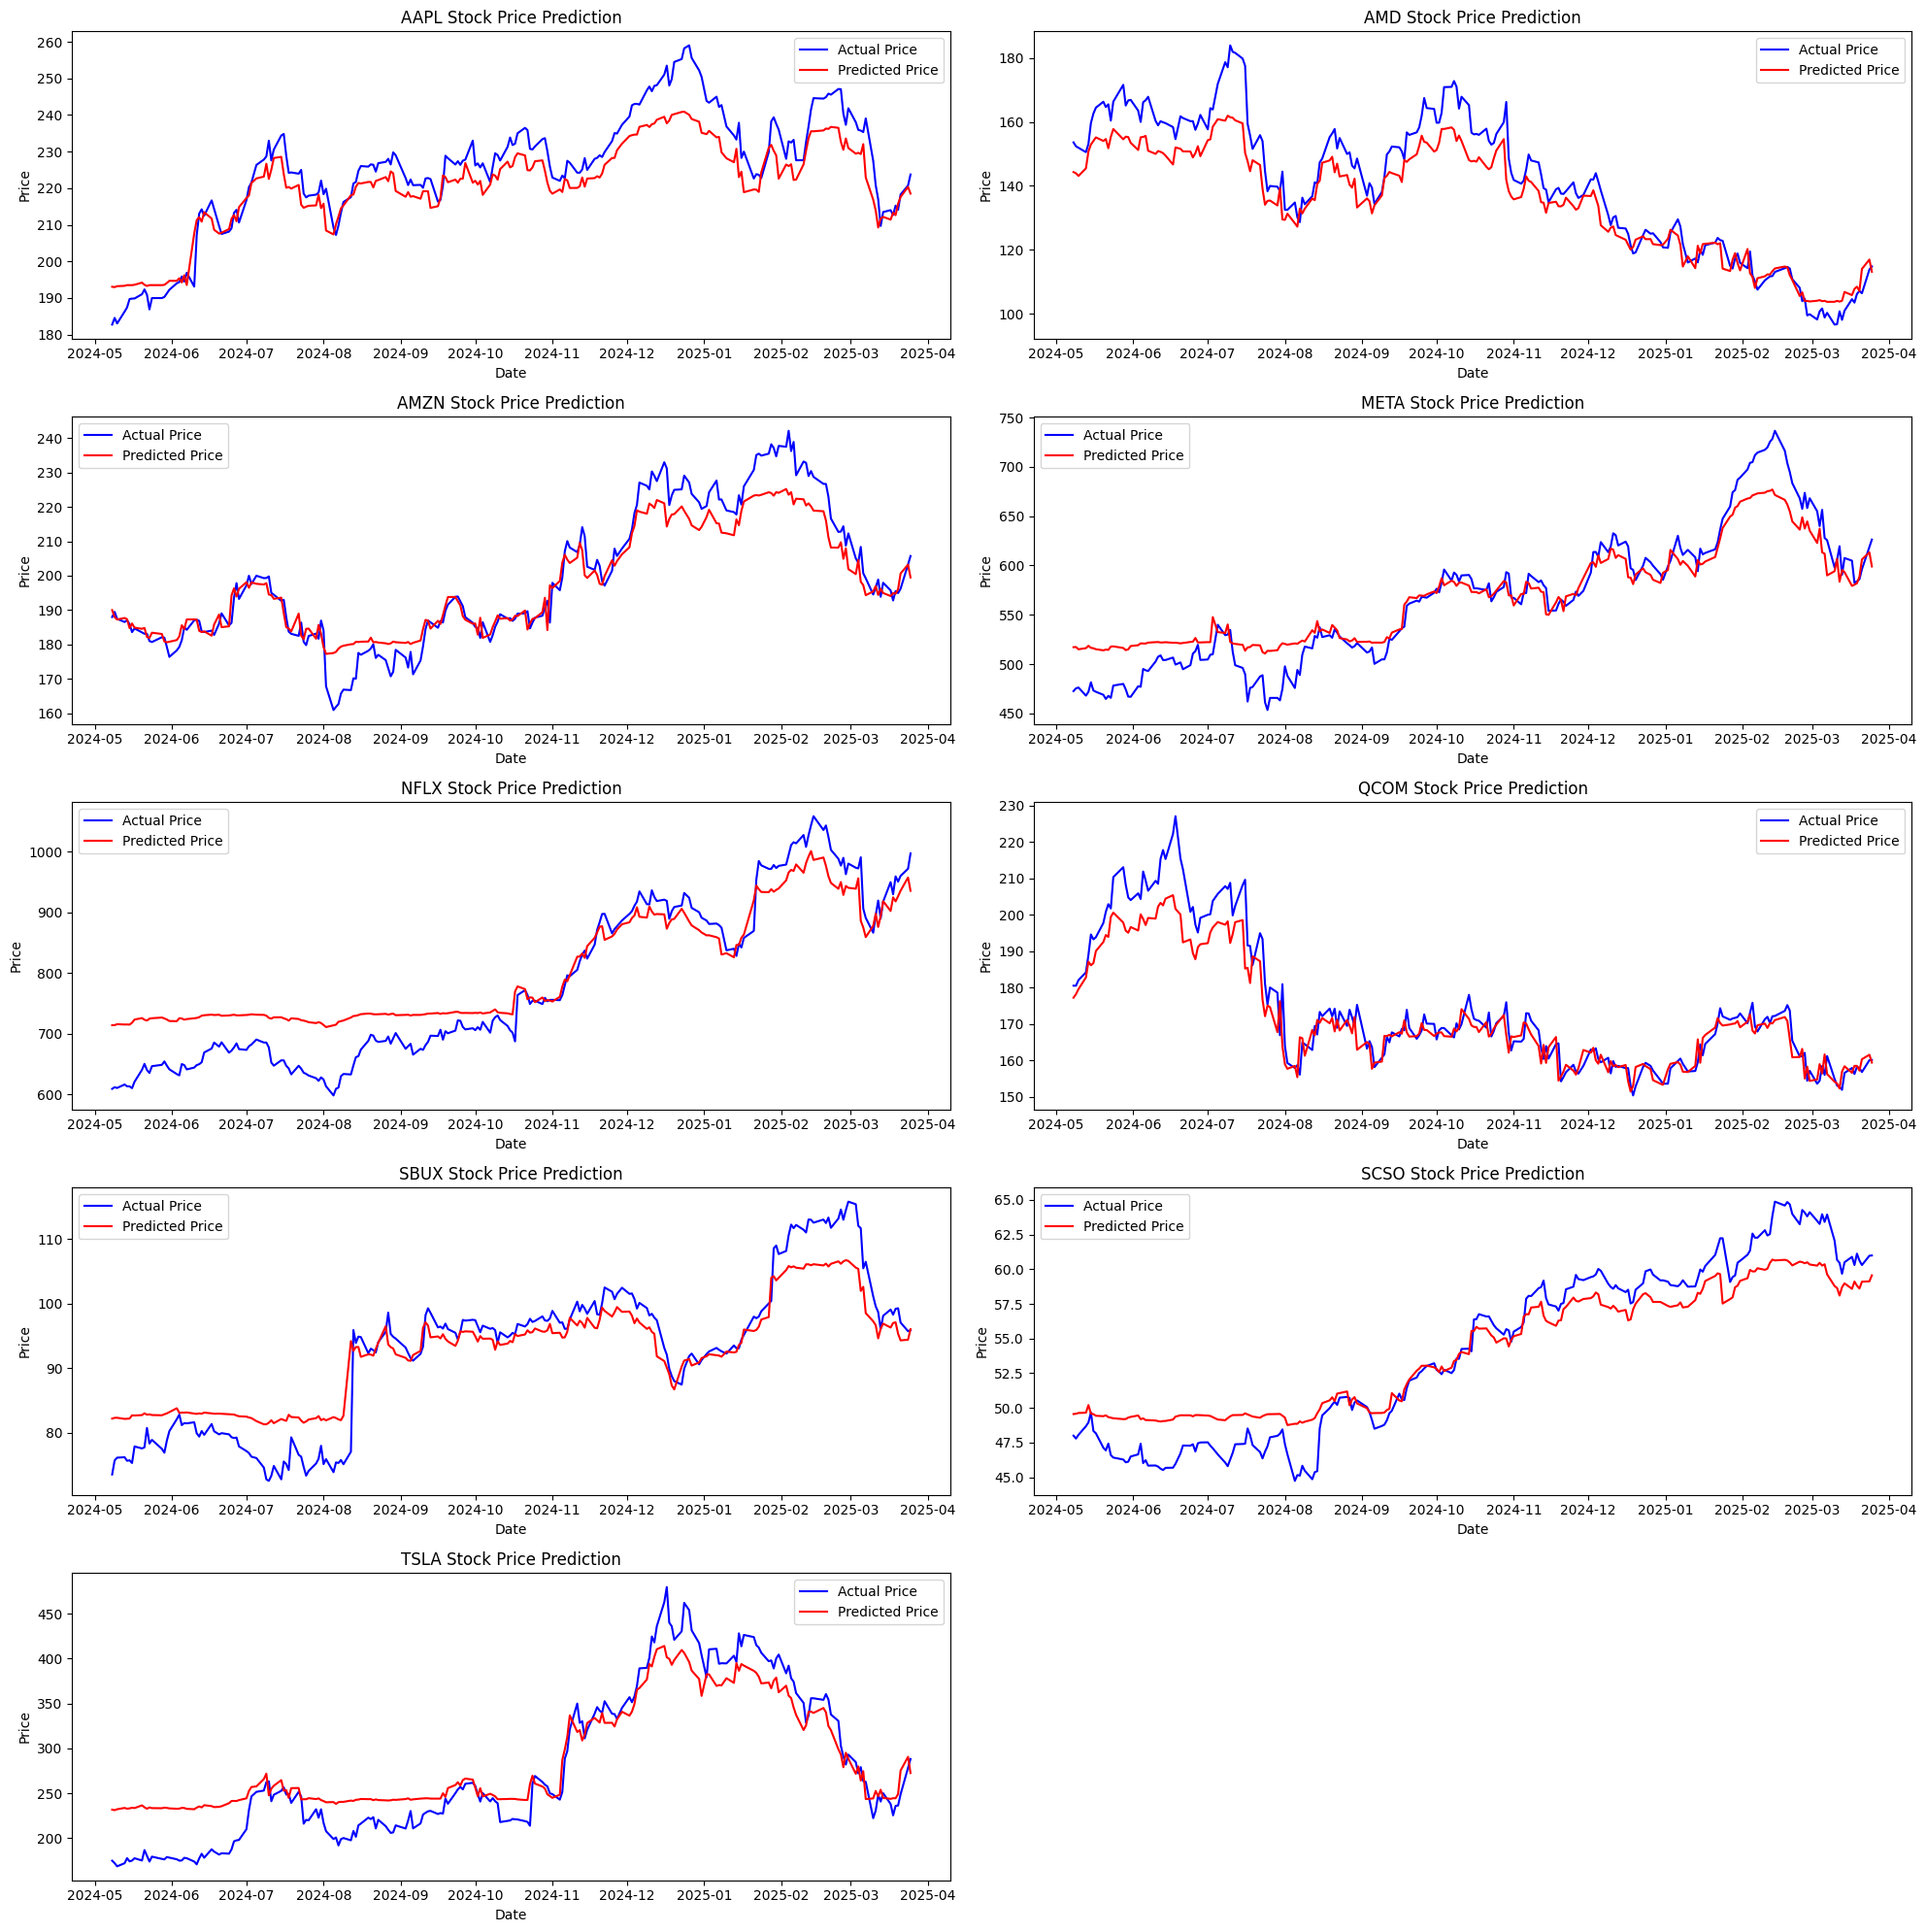

In [128]:
# Crate a 10 subplot grid to show the results for each stock
plt.figure(figsize=(20, 20))
for i, (ticker, (dataframe, X_test, y_test, scaler, results)) in enumerate(test_data.items()):
    # Add the subplot for each stock
    plt.subplot(5, 2, i + 1)
    plt.plot(results['Date'], results['Actual'], label='Actual Price', color='blue')
    plt.plot(results['Date'], results['Prediction'], label='Predicted Price', color='red')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.tight_layout()
plt.show()

### Part 3.2: Use the predective capabilities of the model to simulate trading.

In [129]:
# Organize the trading results into a DataFrame

# Define the buy signal logic
def buy_shares(cash, actual_price_today):
    """
    Buys as many shares as possible with the available cash.
    Returns the updated cash and number of shares bought.
    """
    shares_to_buy = cash // actual_price_today
    cash -= shares_to_buy * actual_price_today
    return cash, shares_to_buy

# Define the sell signal logic
def sell_shares(cash, shares, actual_price_today):
    """
    Sells all shares owned.
    Returns the updated cash and sets shares to 0.
    """
    cash += shares * actual_price_today
    shares = 0
    return cash, shares

# Simulate paper trading for each stock
def simulate_paper_trading(test_data, initial_investment=10000):
    """
    Simulates paper trading for each stock in the test_data dictionary.
    Returns a DataFrame with the final portfolio value and yield for each stock.
    """
    trading_results = []

    for ticker, (dataframe, X_test, y_test, scaler, results) in test_data.items():
        cash = initial_investment
        shares = 0
        portfolio_value = []

        # Iterate through the results DataFrame
        for i in range(len(results) - 1):  # Exclude the last day since we can't predict beyond it
            actual_price_today = results['Actual'].iloc[i]
            predicted_price_tomorrow = results['Prediction'].iloc[i + 1]

            # Buy signal: Predicted price tomorrow > Actual price today
            if predicted_price_tomorrow > actual_price_today:
                cash, shares_bought = buy_shares(cash, actual_price_today)
                shares += shares_bought

            # Sell signal: Predicted price tomorrow < Actual price today
            elif predicted_price_tomorrow < actual_price_today and shares > 0:
                cash, shares = sell_shares(cash, shares, actual_price_today)

            # Calculate the portfolio value (cash + value of shares)
            portfolio_value.append(cash + shares * actual_price_today)

        # Final portfolio value
        final_portfolio_value = cash + shares * results['Actual'].iloc[-1]
        yield_percentage = ((final_portfolio_value - initial_investment) / initial_investment) * 100

        # Store the results
        trading_results.append({
            'Ticker': ticker,
            'Final Portfolio Value': final_portfolio_value,
            'Yield (%)': yield_percentage
        })

        # Print results for the stock
        print(f"Results for {ticker}:")
        print(f"   Final Portfolio Value: ${final_portfolio_value:.2f}")
        print(f"   Yield: {yield_percentage:.2f}%")
        print()

    # Convert trading results to a DataFrame for display
    trading_results_df = pd.DataFrame(trading_results)
    return trading_results_df

# Run the simulation
trading_results_df = simulate_paper_trading(test_data, initial_investment=10000)

# Display the trading results
display(trading_results_df)

Results for AAPL:
   Final Portfolio Value: $9159.59
   Yield: -8.40%

Results for AMD:
   Final Portfolio Value: $9991.00
   Yield: -0.09%

Results for AMZN:
   Final Portfolio Value: $11619.27
   Yield: 16.19%

Results for META:
   Final Portfolio Value: $8932.57
   Yield: -10.67%

Results for NFLX:
   Final Portfolio Value: $8007.13
   Yield: -19.93%

Results for QCOM:
   Final Portfolio Value: $12167.89
   Yield: 21.68%

Results for SBUX:
   Final Portfolio Value: $9629.54
   Yield: -3.70%

Results for SCSO:
   Final Portfolio Value: $9347.09
   Yield: -6.53%

Results for TSLA:
   Final Portfolio Value: $8581.51
   Yield: -14.18%



,Ticker,Final Portfolio Value,Yield (%)
0,AAPL,9159.59,-8.4041
1,AMD,9991.00,-0.0900
2,AMZN,11619.27,16.1927
3,META,8932.57,-10.6743
4,NFLX,8007.13,-19.9287
5,QCOM,12167.89,21.6789
6,SBUX,9629.54,-3.7046
7,SCSO,9347.09,-6.5291
8,TSLA,8581.51,-14.1849


### Part 3.3: Visualize the results of the trading simulation.

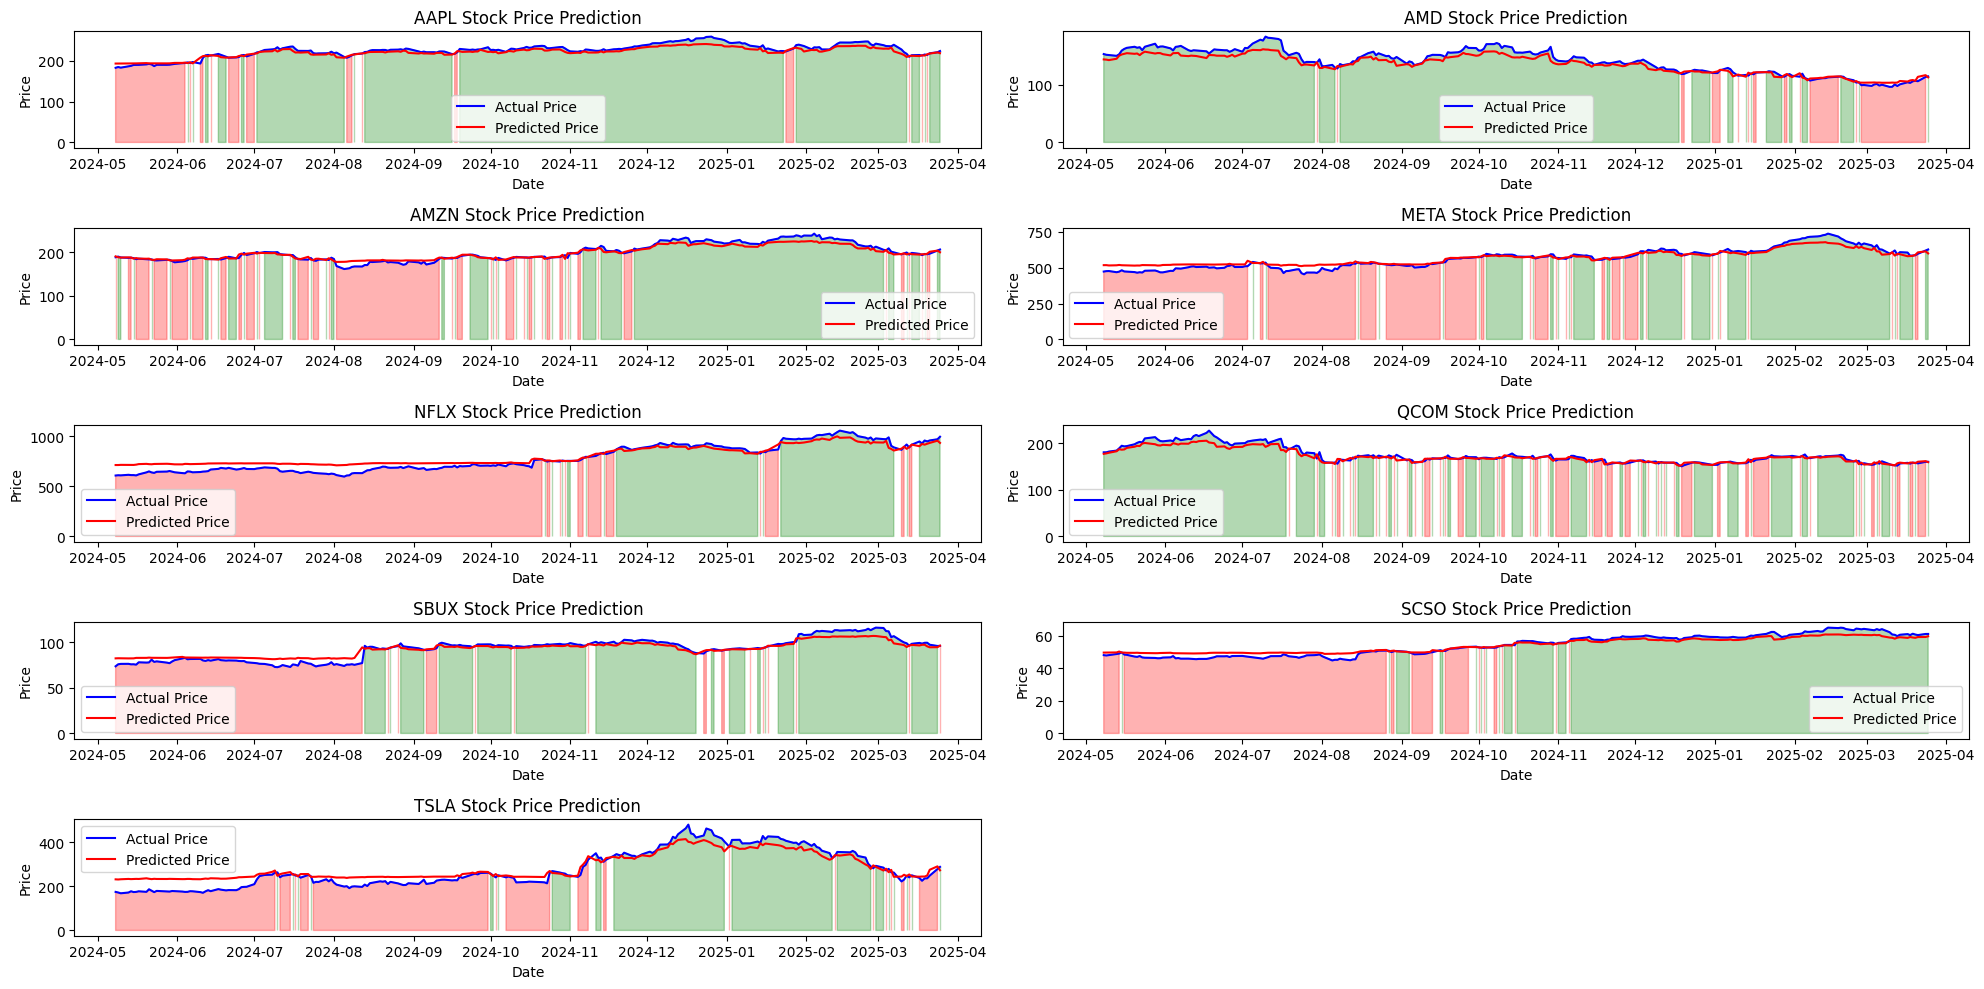

In [130]:
# Plot these results for each stock with red and green lines for gains and losses
plt.figure(figsize=(20, 10))
for i, (ticker, (dataframe, X_test, y_test, scaler, results)) in enumerate(test_data.items()):
    # Add the subplot for each stock
    plt.subplot(5, 2, i + 1)
    plt.plot(results['Date'], results['Actual'], label='Actual Price', color='blue')
    plt.plot(results['Date'], results['Prediction'], label='Predicted Price', color='red')
    
    # Highlight gains and losses
    gains = results['Actual'] > results['Prediction']
    losses = results['Actual'] < results['Prediction']
    
    plt.fill_between(results['Date'], results['Actual'], where=gains, color='green', alpha=0.3)
    plt.fill_between(results['Date'], results['Actual'], where=losses, color='red', alpha=0.3)
    
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.tight_layout()
plt.show()


In [131]:
# Print a header
print("\n{:<8} {:<22} {:<10}".format('Ticker', 'Final Portfolio Value', 'Yield (%)'))
print("-" * 45)

# Iterate through the test data and print colored results
for ticker, (dataframe, X_test, y_test, scaler, results) in test_data.items():
    final_value = trading_results_df.loc[trading_results_df['Ticker'] == ticker, 'Final Portfolio Value'].values[0]
    yield_pct = trading_results_df.loc[trading_results_df['Ticker'] == ticker, 'Yield (%)'].values[0]
    
    # Format the values
    final_value_str = "${:.2f}".format(final_value)
    yield_str = "{:.2f}%".format(yield_pct)
    
    # Color based on yield (green for positive, red for negative)
    if yield_pct >= 0:
        colored_yield = colored(yield_str, 'green')
    else:
        colored_yield = colored(yield_str, 'red')
    
    # Print the row
    print("{:<8} {:<22} {}".format(ticker, final_value_str, colored_yield))


Ticker   Final Portfolio Value  Yield (%) 
---------------------------------------------
AAPL     $9159.59               -8.40%
AMD      $9991.00               -0.09%
AMZN     $11619.27              16.19%
META     $8932.57               -10.67%
NFLX     $8007.13               -19.93%
QCOM     $12167.89              21.68%
SBUX     $9629.54               -3.70%
SCSO     $9347.09               -6.53%
TSLA     $8581.51               -14.18%


### Part 3.4: Store the results of the simulated trading.

In [132]:
  # Create a dataframe from the results.
dataframe_columns = ['Ticker', 'Actual', 'Prediction', 'Date']
trading_results_df = pd.DataFrame(columns=dataframe_columns)
for ticker, (dataframe, X_test, y_test, scaler, results) in test_data.items():
    # Create a DataFrame for the results
    results_df = pd.DataFrame({
        'Ticker': ticker,
        'Actual': results['Actual_Scaled'],
        'Prediction': results['Prediction_Scaled'],
        'Date': results['Date']
    })
    
    # Append to the main DataFrame
    trading_results_df = pd.concat([trading_results_df, results_df], ignore_index=True)
    
# Display the trading results DataFrame
display(trading_results_df)

/tmp/ipykernel_27534/2151910772.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trading_results_df = pd.concat([trading_results_df, results_df], ignore_index=True)


,Ticker,Actual,Prediction,Date
0,AAPL,0.592725,0.532328,2025-03-25
1,AAPL,0.557852,0.553596,2025-03-24
2,AAPL,0.529446,0.521709,2025-03-21
3,AAPL,0.481293,0.500552,2025-03-20
4,AAPL,0.494457,0.464448,2025-03-19
...,...,...,...,...
1975,TSLA,0.029160,0.206345,2024-05-14
1976,TSLA,0.010983,0.209055,2024-05-13
1977,TSLA,0.000000,0.204308,2024-05-10
1978,TSLA,0.011240,0.200990,2024-05-09


### Part 3.5: Explote the accuracy of the model prediction.

In [133]:
# Define a function to calculate the accuracy for a stock in a given week with the results DataFrame
def calculate_weekly_accuracy(results, week: int, year: int):
    """
    Calculate the accuracy of predictions for a given week.
    """
    # Convert the 'Date' column to datetime format
    results['Date'] = pd.to_datetime(results['Date'])
    
    # Filter the results for the given week and year
    week_start = pd.to_datetime(f'{year}-W{week}-1', format='%Y-W%W-%w')
    week_end = week_start + pd.DateOffset(days=6)
    weekly_results = results[(results['Date'] >= week_start) & (results['Date'] <= week_end)]
    
    # Calculate the accuracy
    correct_predictions = ((weekly_results['Actual'] - weekly_results['Prediction']).abs() < 0.05 * weekly_results['Actual']).sum()
    total_predictions = len(weekly_results)
    
    if total_predictions == 0:
        return 0.0
    
    accuracy = correct_predictions / total_predictions
    return accuracy

In [134]:
# Show the weekly accuracy for each stock, using a colored table
for ticker, (dataframe, X_test, y_test, scaler, results) in test_data.items():
    # Calculate the weekly accuracy for the current year
    current_year = datetime.datetime.now().year
    weekly_accuracy = []
    
    for week in range(1, 10):
        accuracy = calculate_weekly_accuracy(results, week, current_year)
        weekly_accuracy.append(accuracy)
    
    # Create a DataFrame to hold the weekly accuracy
    weekly_accuracy_df = pd.DataFrame({
        'Week': range(1, 10),
        'Accuracy': weekly_accuracy
    })
    
    # Print the results
    print(f"Weekly Accuracy for {ticker}:")
    
    # Print colored results
    for index, row in weekly_accuracy_df.iterrows():
        week_str = f"Week {row['Week']}"
        accuracy_str = "{:.2f}%".format(row['Accuracy'] * 100)
        
        # Color based on accuracy (green for high accuracy, red for low accuracy)
        if row['Accuracy'] >= 0.8:
            colored_accuracy = colored(accuracy_str, 'green')
        elif row['Accuracy'] >= 0.5:
            colored_accuracy = colored(accuracy_str, 'yellow')
        else:
            colored_accuracy = colored(accuracy_str, 'red')
        
        # Print the row
        print(f"{week_str}: {colored_accuracy}")
    print()

Weekly Accuracy for AAPL:
Week 1.0: 75.00%
Week 2.0: 80.00%
Week 3.0: 100.00%
Week 4.0: 80.00%
Week 5.0: 100.00%
Week 6.0: 100.00%
Week 7.0: 100.00%
Week 8.0: 80.00%
Week 9.0: 80.00%

Weekly Accuracy for AMD:
Week 1.0: 75.00%
Week 2.0: 100.00%
Week 3.0: 75.00%
Week 4.0: 100.00%
Week 5.0: 60.00%
Week 6.0: 100.00%
Week 7.0: 100.00%
Week 8.0: 100.00%
Week 9.0: 60.00%

Weekly Accuracy for AMZN:
Week 1.0: 75.00%
Week 2.0: 100.00%
Week 3.0: 75.00%
Week 4.0: 40.00%
Week 5.0: 20.00%
Week 6.0: 80.00%
Week 7.0: 75.00%
Week 8.0: 100.00%
Week 9.0: 100.00%

Weekly Accuracy for META:
Week 1.0: 100.00%
Week 2.0: 100.00%
Week 3.0: 100.00%
Week 4.0: 100.00%
Week 5.0: 40.00%
Week 6.0: 0.00%
Week 7.0: 0.00%
Week 8.0: 80.00%
Week 9.0: 60.00%

Weekly Accuracy for NFLX:
Week 1.0: 75.00%
Week 2.0: 100.00%
Week 3.0: 75.00%
Week 4.0: 100.00%
Week 5.0: 100.00%
Week 6.0: 60.00%
Week 7.0: 25.00%
Week 8.0: 60.00%
Week 9.0: 80.00%

Weekly Accuracy for QCOM:
Week 1.0: 100.00%
Week 2.0: 100.00%
Week 3.0: 100.00%
Week

## Part 4: Create prediction evaluation metrics

### Part 4.1: Evaluate and store some metrics for the model prediction.

In [135]:
# DataFrame to hold the evaluation metrics
evaluation_metrics = pd.DataFrame(columns=['Ticker', 'MSE', 'RMSE', 'MAE', 'R2'])

# Providide the MSE< RMSE, MAE, and R2 for each stock (Note small sample size and specificity of the data)
for ticker, (dataframe, X_test, y_test, scaler, results) in test_data.items():
    # Calculate the Mean Squared Error (MSE)
    mse_value = mean_squared_error(y_test, results['Prediction_Scaled'].values)
    
    # Calculate the Root Mean Squared Error (RMSE)
    rmse_value = np.sqrt(mse_value)
    
    # Calculate the Mean Absolute Error (MAE)
    mae_value = mean_absolute_error(y_test, results['Prediction_Scaled'].values)
    
    # Calculate the R-squared value
    r2_value = r2_score(y_test, results['Prediction_Scaled'].values)
    
    # Store the metrics in the DataFrame
    evaluation_metrics_row = pd.DataFrame({
        'Ticker': [ticker],
        'MSE': [mse_value],
        'RMSE': [rmse_value],
        'MAE': [mae_value],
        'R2': [r2_value]
    })
    evaluation_metrics = pd.concat([evaluation_metrics, evaluation_metrics_row], ignore_index=True)
    
    # Print the results
    print(f"Results for {ticker}:")
    print(f"   MSE: {mse_value:.4f}")
    print(f"   RMSE: {rmse_value:.4f}")
    print(f"   MAE: {mae_value:.4f}")
    print(f"   R-squared: {r2_value:.4f}")
    print()

Results for AAPL:
   MSE: 0.0062
   RMSE: 0.0789
   MAE: 0.0649
   R-squared: 0.8171

Results for AMD:
   MSE: 0.0061
   RMSE: 0.0781
   MAE: 0.0621
   R-squared: 0.8533

Results for AMZN:
   MSE: 0.0061
   RMSE: 0.0784
   MAE: 0.0582
   R-squared: 0.8946

Results for META:
   MSE: 0.0075
   RMSE: 0.0864
   MAE: 0.0662
   R-squared: 0.8693

Results for NFLX:
   MSE: 0.0090
   RMSE: 0.0948
   MAE: 0.0780
   R-squared: 0.8423

Results for QCOM:
   MSE: 0.0037
   RMSE: 0.0605
   MAE: 0.0428
   R-squared: 0.8781

Results for SBUX:
   MSE: 0.0101
   RMSE: 0.1004
   MAE: 0.0793
   R-squared: 0.8560

Results for SCSO:
   MSE: 0.0107
   RMSE: 0.1036
   MAE: 0.0872
   R-squared: 0.8854

Results for TSLA:
   MSE: 0.0102
   RMSE: 0.1008
   MAE: 0.0824
   R-squared: 0.8556



/tmp/ipykernel_27534/4016733649.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evaluation_metrics = pd.concat([evaluation_metrics, evaluation_metrics_row], ignore_index=True)


In [136]:
# Display the evaluation metrics
display(evaluation_metrics)

,Ticker,MSE,RMSE,MAE,R2
0,AAPL,0.006221,0.078872,0.064865,0.817112
1,AMD,0.006104,0.078125,0.062114,0.853287
2,AMZN,0.006141,0.078362,0.058214,0.894576
3,META,0.007459,0.086367,0.066172,0.869324
4,NFLX,0.008978,0.094753,0.077972,0.842306
5,QCOM,0.003661,0.060504,0.042815,0.878138
6,SBUX,0.010088,0.100440,0.079278,0.856026
7,SCSO,0.010726,0.103565,0.087238,0.885380
8,TSLA,0.010167,0.100834,0.082391,0.855568


### Part 4.2: Create Evaluation metrics per weeks.

In [137]:
def get_weeek_of_dataframe(df, ticker, start_date, end_date):
    
    # Slice the data for the specific ticker.
    df = df[df['Ticker'] == ticker]
    
    # Slice the data for the specific date range.
    df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

    # return a copy of the dataframe
    return df.copy()


# Calculate the weekly metric for each stock
def calculate_weekly_metric(data, start_date='2025-01-01', weeks=10):
    weekly_metrics = pd.DataFrame(columns=['Ticker', 'Week', 'Metric', 'Value'])

    for ticker in data['Ticker'].unique():
        # Slice the partial data for the specific ticker.
        current_data = data[data['Ticker'] == ticker]
        
        # Slice the data for each date range.
        for week in range(1, weeks):
            # Get the data for the specific week
            begin_date = datetime.datetime.strptime(start_date, '%Y-%m-%d') + datetime.timedelta(weeks=week-1)
            end_date = begin_date + datetime.timedelta(weeks=1)
            
            # Filter the data for the specific week
            results_filtered = get_weeek_of_dataframe(current_data, 
                                                      ticker, 
                                                      start_date=start_date,
                                                      end_date=end_date)
            
            # Check if the filtered DataFrame is empty
            if results_filtered.empty:
                print(f"No data available for {ticker} from {start_date} to {end_date}.")
                continue
            
            # Calculate the metrics for the week.
            actual_prices = results_filtered['Actual'].values
            predicted_prices = results_filtered['Prediction'].values

            # Calculate each metric
            mse_value = mean_squared_error(actual_prices, predicted_prices)
            rmse_value = np.sqrt(mse_value)
            mae_value = mean_absolute_error(actual_prices, predicted_prices)
            r2_value = r2_score(actual_prices, predicted_prices)
            
            # Create a DataFrame for the metrics
            metrics_df = pd.DataFrame({
                'Ticker': [ticker] * 4,
                'Week': [week] * 4,
                'Metric': ['MSE', 'RMSE', 'MAE', 'R2'],
                'Value': [mse_value, rmse_value, mae_value, r2_value]
            })
            
            # Append the metrics DataFrame to the weekly_metrics DataFrame
            weekly_metrics = pd.concat([weekly_metrics, metrics_df], ignore_index=True)
            
    # Return the weekly metrics DataFrame
    return weekly_metrics

# Calculate the weekly metrics for each stock
weekly_metrics = calculate_weekly_metric(trading_results_df)

# Pivot the DataFrame to have metrics as columns
weekly_metrics_pivot = weekly_metrics.pivot_table(index=['Ticker', 'Week'], columns='Metric', values='Value').reset_index()

# Display the weekly metrics DataFrame
display(weekly_metrics_pivot)

/tmp/ipykernel_27534/820522056.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  weekly_metrics = pd.concat([weekly_metrics, metrics_df], ignore_index=True)


Metric,Ticker,Week,MAE,MSE,R2,RMSE
0,AAPL,1,0.113055,0.013280,-105.691589,0.115238
1,AAPL,2,0.105623,0.012648,-4.534900,0.112464
2,AAPL,3,0.092688,0.010432,-0.420371,0.102139
3,AAPL,4,0.081700,0.008650,-0.113285,0.093003
4,AAPL,5,0.082145,0.008725,-0.359422,0.093407
...,...,...,...,...,...,...
76,TSLA,5,0.083962,0.008301,-3.314987,0.091108
77,TSLA,6,0.079350,0.007689,-0.244055,0.087686
78,TSLA,7,0.075532,0.007047,-0.019042,0.083944
79,TSLA,8,0.074007,0.006765,0.429906,0.082251


## Part 5: Plot and explore the evaluation metrics.

### Part 5.1: Show the metrics per weeks.

<Figure size 2000x1000 with 0 Axes>

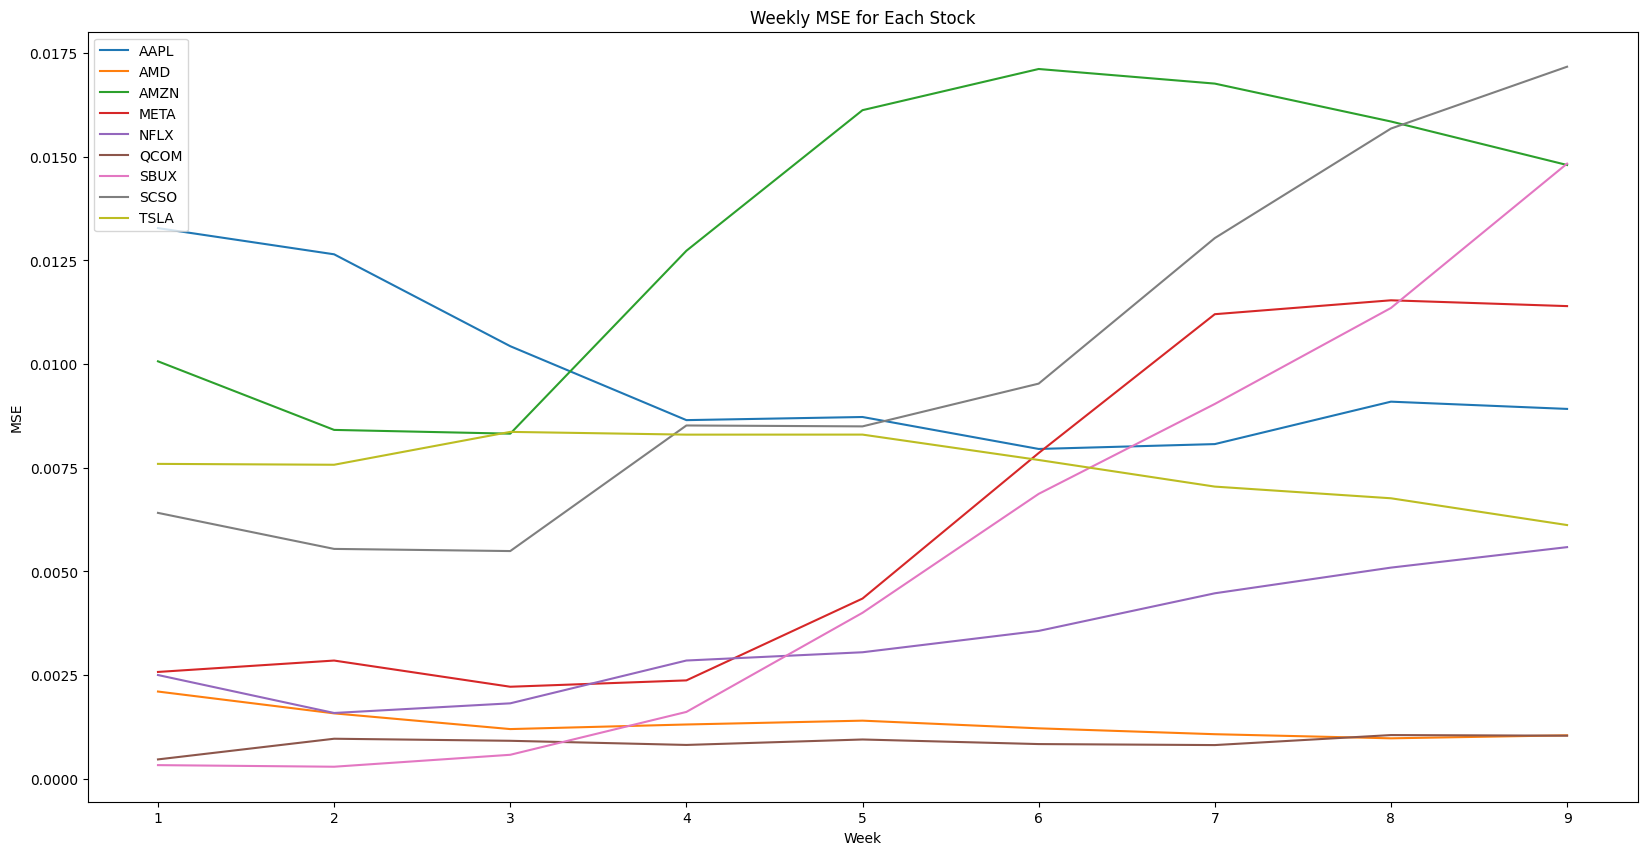

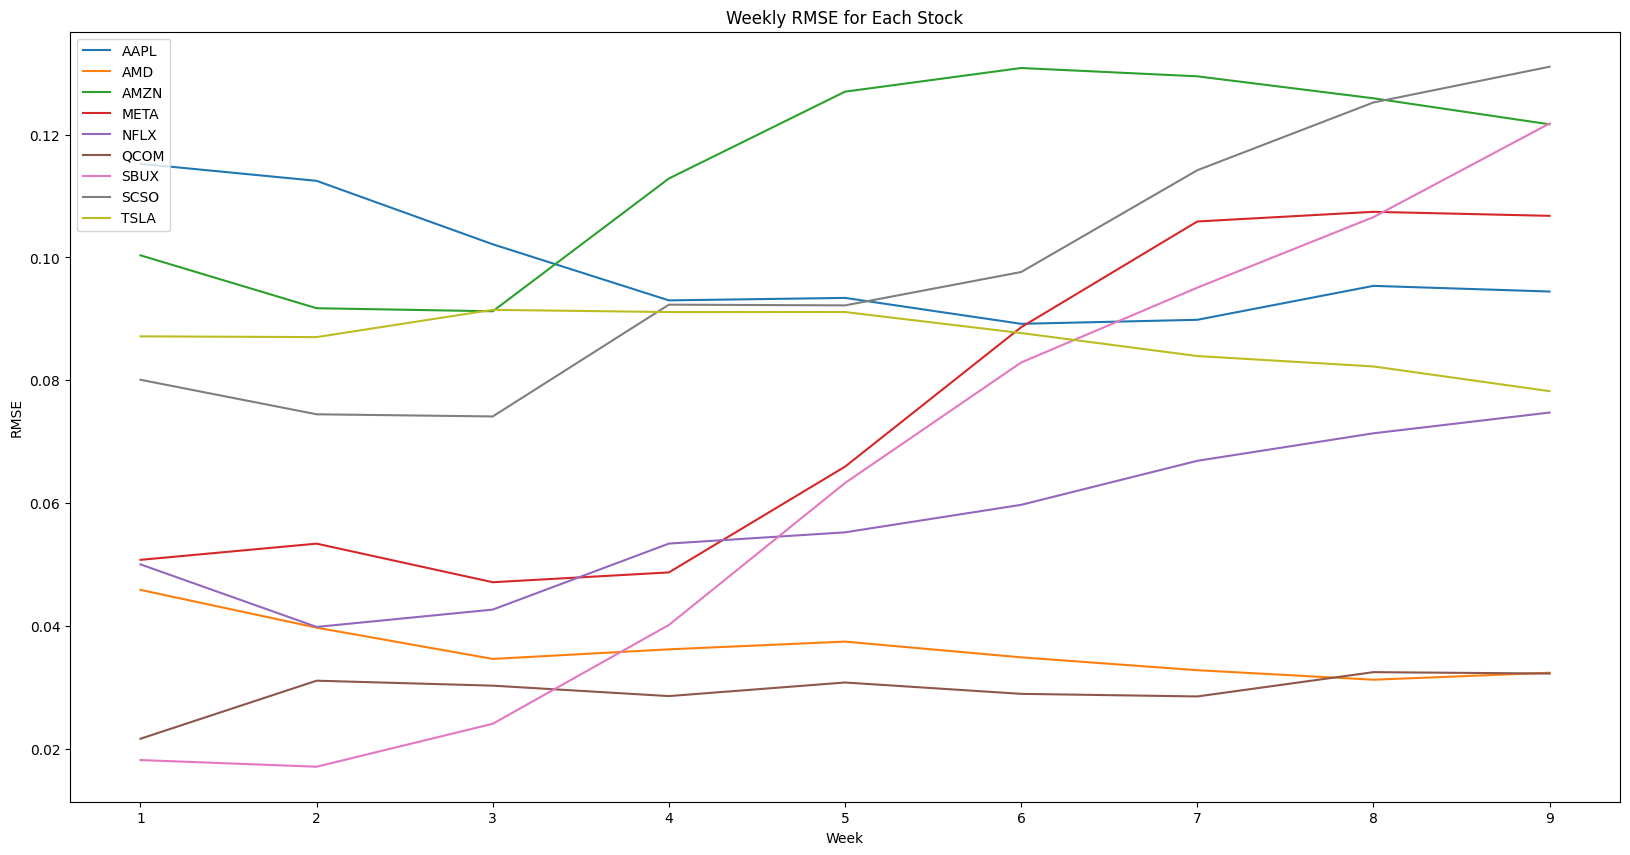

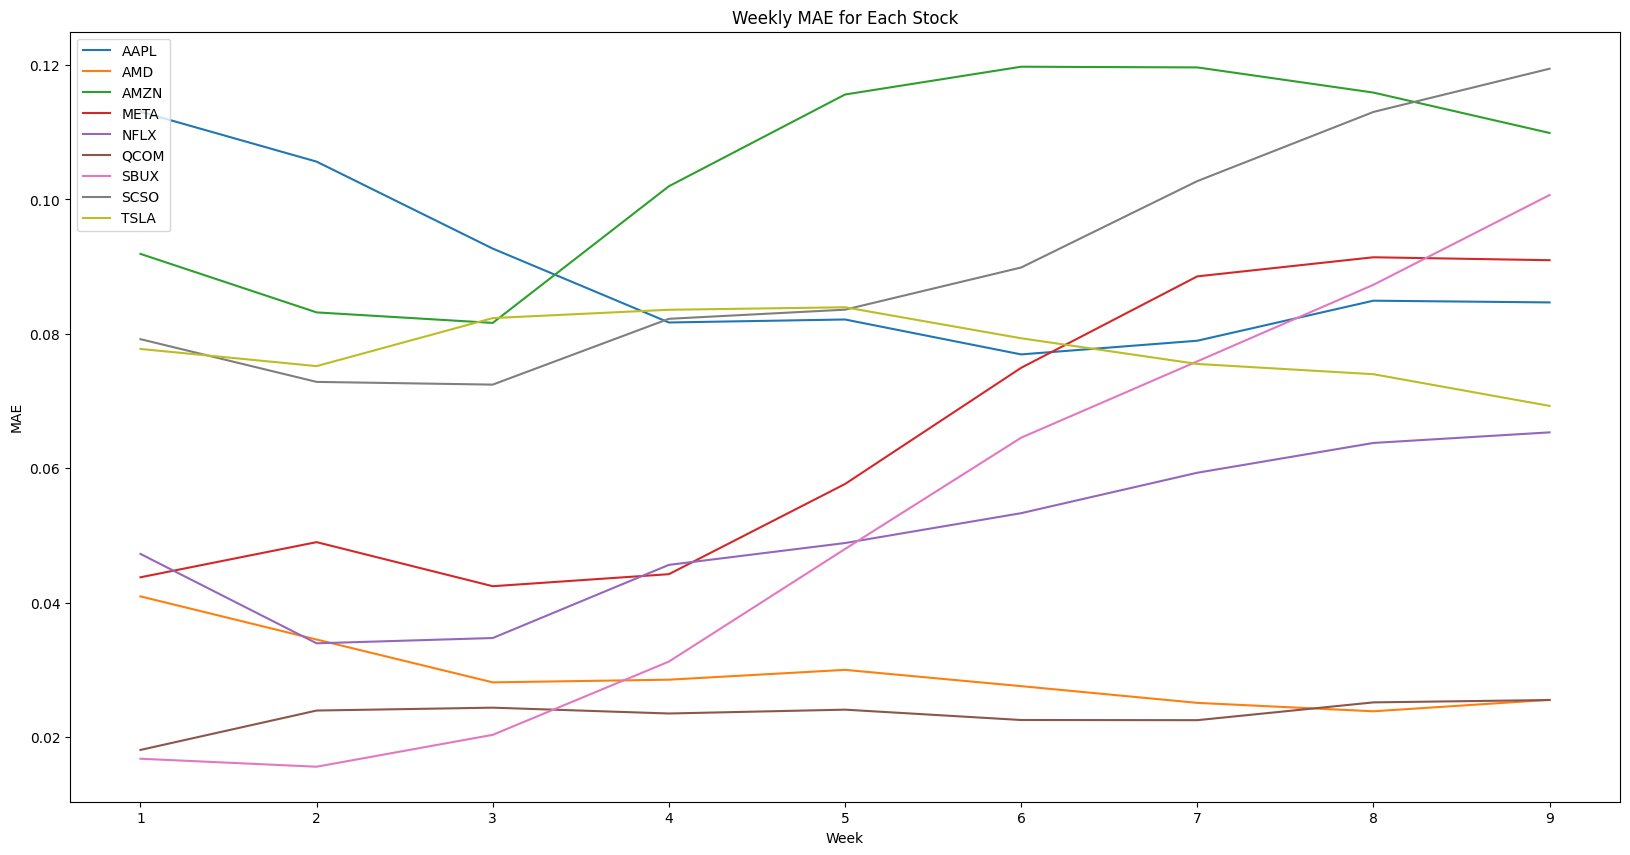

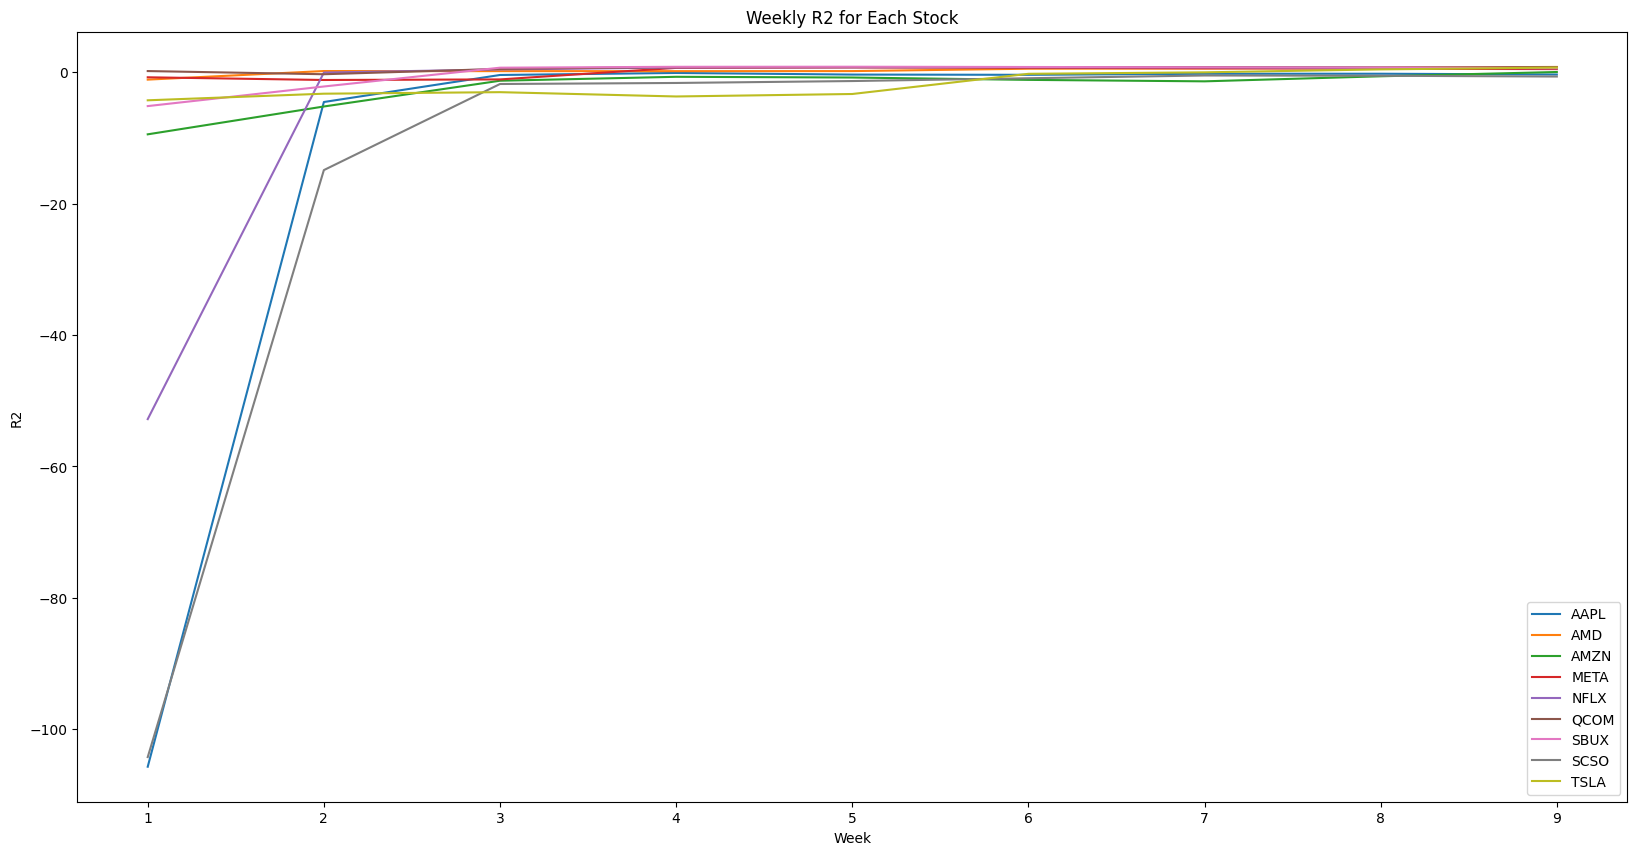

In [138]:
# Plot the weekly metrics for each stock, where the stocks are superimposed on each other
plt.figure(figsize=(20, 10))
for metric in ['MSE', 'RMSE', 'MAE', 'R2']:
    plt.figure(figsize=(20, 10))
    for ticker in weekly_metrics_pivot['Ticker'].unique():
        # Filter the data for the specific ticker
        ticker_data = weekly_metrics_pivot[weekly_metrics_pivot['Ticker'] == ticker]
        
        # Plot the metric
        plt.plot(ticker_data['Week'], ticker_data[metric], label=ticker)
    
    # Add labels and title
    plt.title(f'Weekly {metric} for Each Stock')
    plt.xlabel('Week')
    plt.ylabel(metric)
    plt.legend()
    plt.show()


### Part 5.2: Reframe the data tables and calculate metrics cumulatively.

In [139]:
# Calculate weekly metrics per all stocks
weekly_metrics_all = pd.DataFrame(columns=['Week', 'Metric', 'Value'])
weeks = 10

# Add wee label date...
def get_week_label(date):
    # Get the week after the start date.
    start_date = datetime.datetime.strptime('2025-01-01', '%Y-%m-%d')
    week = ((date - start_date).days // 7)+ 1
    return week

# Add the week label to the dataframe
trading_results_df['Week'] = trading_results_df['Date'].apply(get_week_label)

# Note: Some weeks are negative since the start date is prior to the first date.

# Display the updated dataframe
display(trading_results_df)

,Ticker,Actual,Prediction,Date,Week
0,AAPL,0.592725,0.532328,2025-03-25,12
1,AAPL,0.557852,0.553596,2025-03-24,12
2,AAPL,0.529446,0.521709,2025-03-21,12
3,AAPL,0.481293,0.500552,2025-03-20,12
4,AAPL,0.494457,0.464448,2025-03-19,12
...,...,...,...,...,...
1975,TSLA,0.029160,0.206345,2024-05-14,-33
1976,TSLA,0.010983,0.209055,2024-05-13,-33
1977,TSLA,0.000000,0.204308,2024-05-10,-33
1978,TSLA,0.011240,0.200990,2024-05-09,-33


In [140]:
# Function to calculate weekly metrics across all stocks
def calculate_weekly_metric_all(data):
    weeks = [week for week in data['Week'].unique() if week > 0]
    weekly_metrics = pd.DataFrame(columns=['Week', 'Metric', 'Value'])
    max_weeks = max(weeks)

    for week in range(1, max_weeks + 1):
        # Get the data for the specific week
        results_filtered = data[data['Week'] == week]
        
        # Check if the filtered DataFrame is empty
        if results_filtered.empty:
            print(f"No data available for week {week}.")
            continue
        
        # Calculate the metrics for the week.
        actual_prices = results_filtered['Actual'].values
        predicted_prices = results_filtered['Prediction'].values

        # Calculate each metric
        mse_value = mean_squared_error(actual_prices, predicted_prices)
        rmse_value = np.sqrt(mse_value)
        mae_value = mean_absolute_error(actual_prices, predicted_prices)
        r2_value = r2_score(actual_prices, predicted_prices)
        
        # Create a DataFrame for the metrics
        metrics_df = pd.DataFrame({
            'Week': [week] * 4,
            'Metric': ['MSE', 'RMSE', 'MAE', 'R2'],
            'Value': [mse_value, rmse_value, mae_value, r2_value]
        })
        
        # Append the metrics DataFrame to the weekly_metrics DataFrame
        weekly_metrics = pd.concat([weekly_metrics, metrics_df], ignore_index=True)
            
    # Return the weekly metrics DataFrame
    return weekly_metrics

In [141]:
# Calculate the weekly metric for all stocks
weekly_metrics_all = calculate_weekly_metric_all(trading_results_df)

# Pivot the DataFrame to have metrics as columns
weekly_metrics_all_pivot = weekly_metrics_all.pivot_table(index='Week', columns='Metric', values='Value').reset_index()

# Display the weekly metrics DataFrame
display(weekly_metrics_all_pivot)

/tmp/ipykernel_27534/1766396223.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  weekly_metrics = pd.concat([weekly_metrics, metrics_df], ignore_index=True)


Metric,Week,MAE,MSE,R2,RMSE
0,1,0.055350,0.004520,0.831456,0.067233
1,2,0.050653,0.003835,0.848358,0.061928
2,3,0.053264,0.004608,0.826078,0.067882
3,4,0.067594,0.007061,0.725229,0.084031
4,5,0.079573,0.008701,0.721312,0.093281
5,6,0.089758,0.011017,0.750770,0.104964
6,7,0.094235,0.013424,0.717120,0.115862
7,8,0.098616,0.013171,0.733466,0.114766
8,9,0.083928,0.010760,0.836100,0.103730
9,10,0.078437,0.009898,0.815253,0.099489


### Part 5.3: View the cumulative metrics.

<Figure size 2000x1000 with 0 Axes>

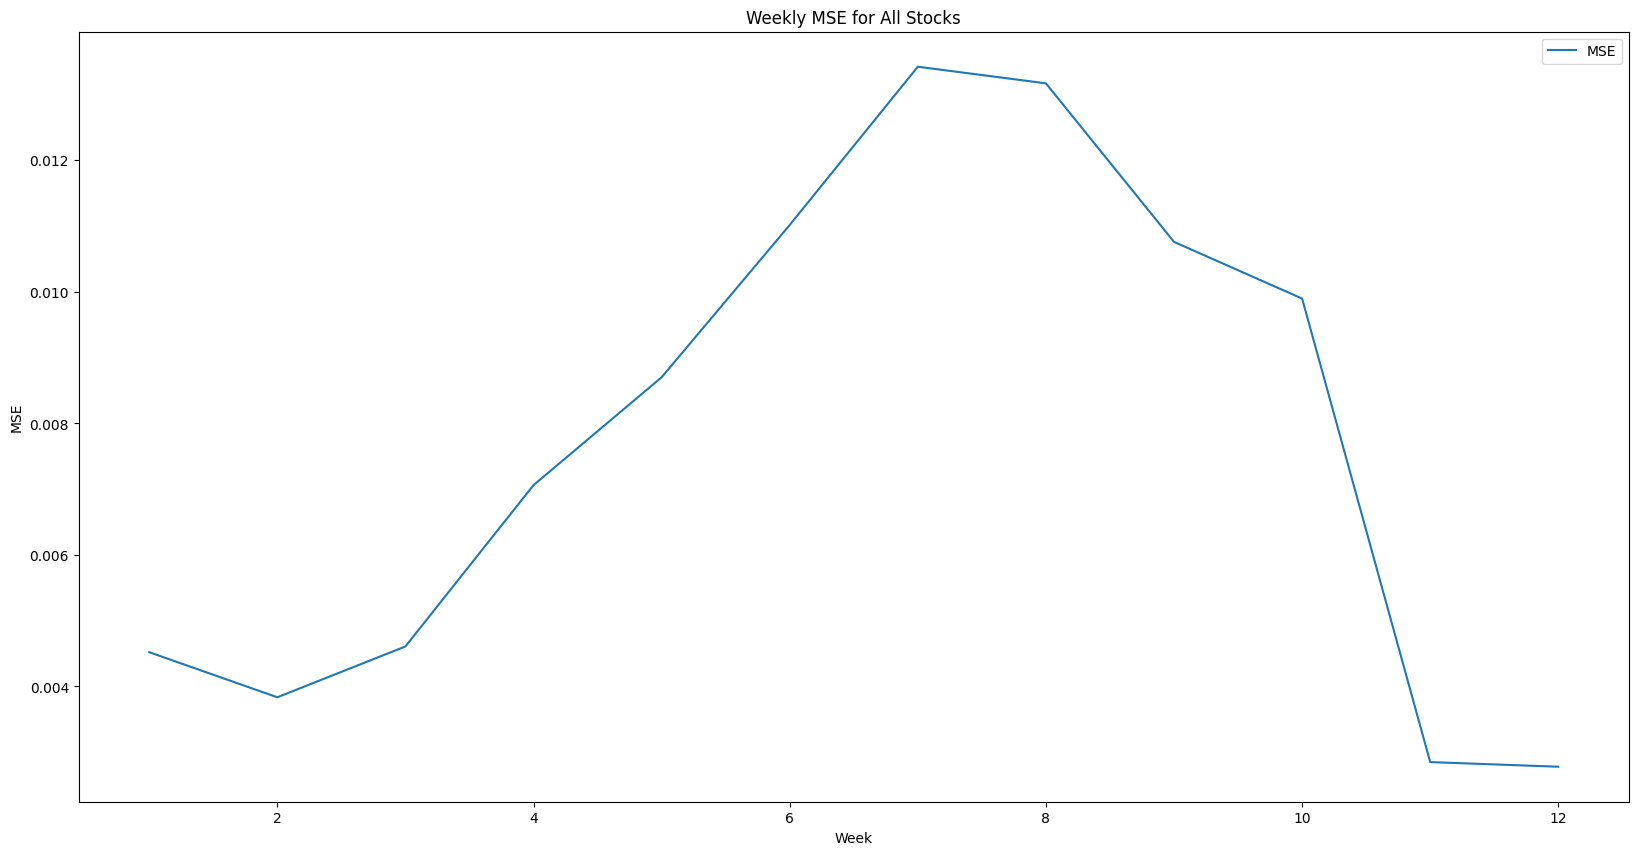

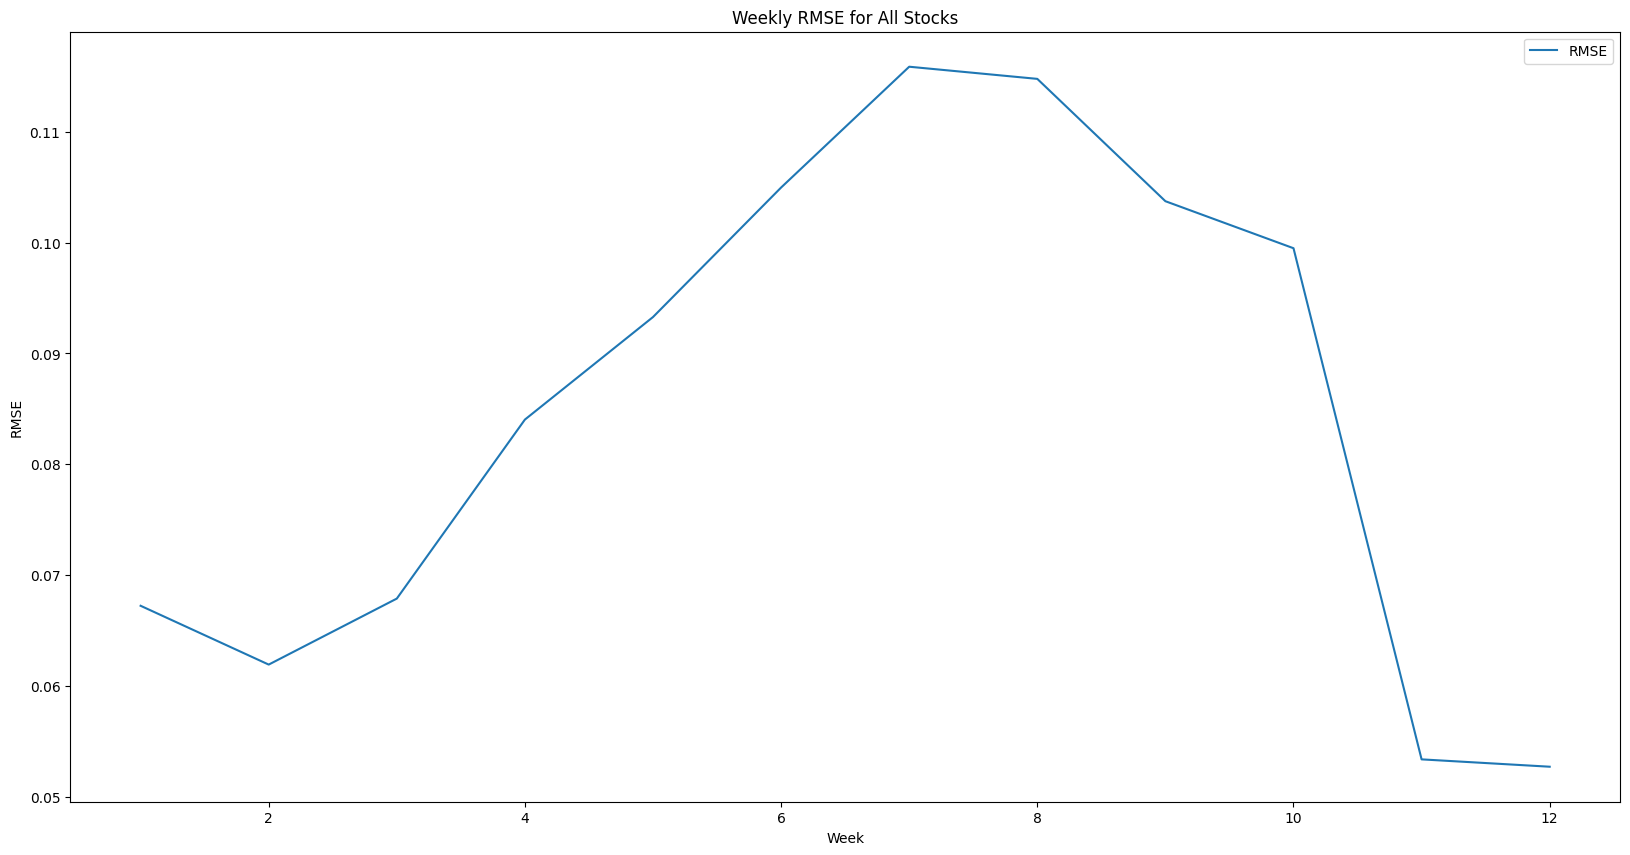

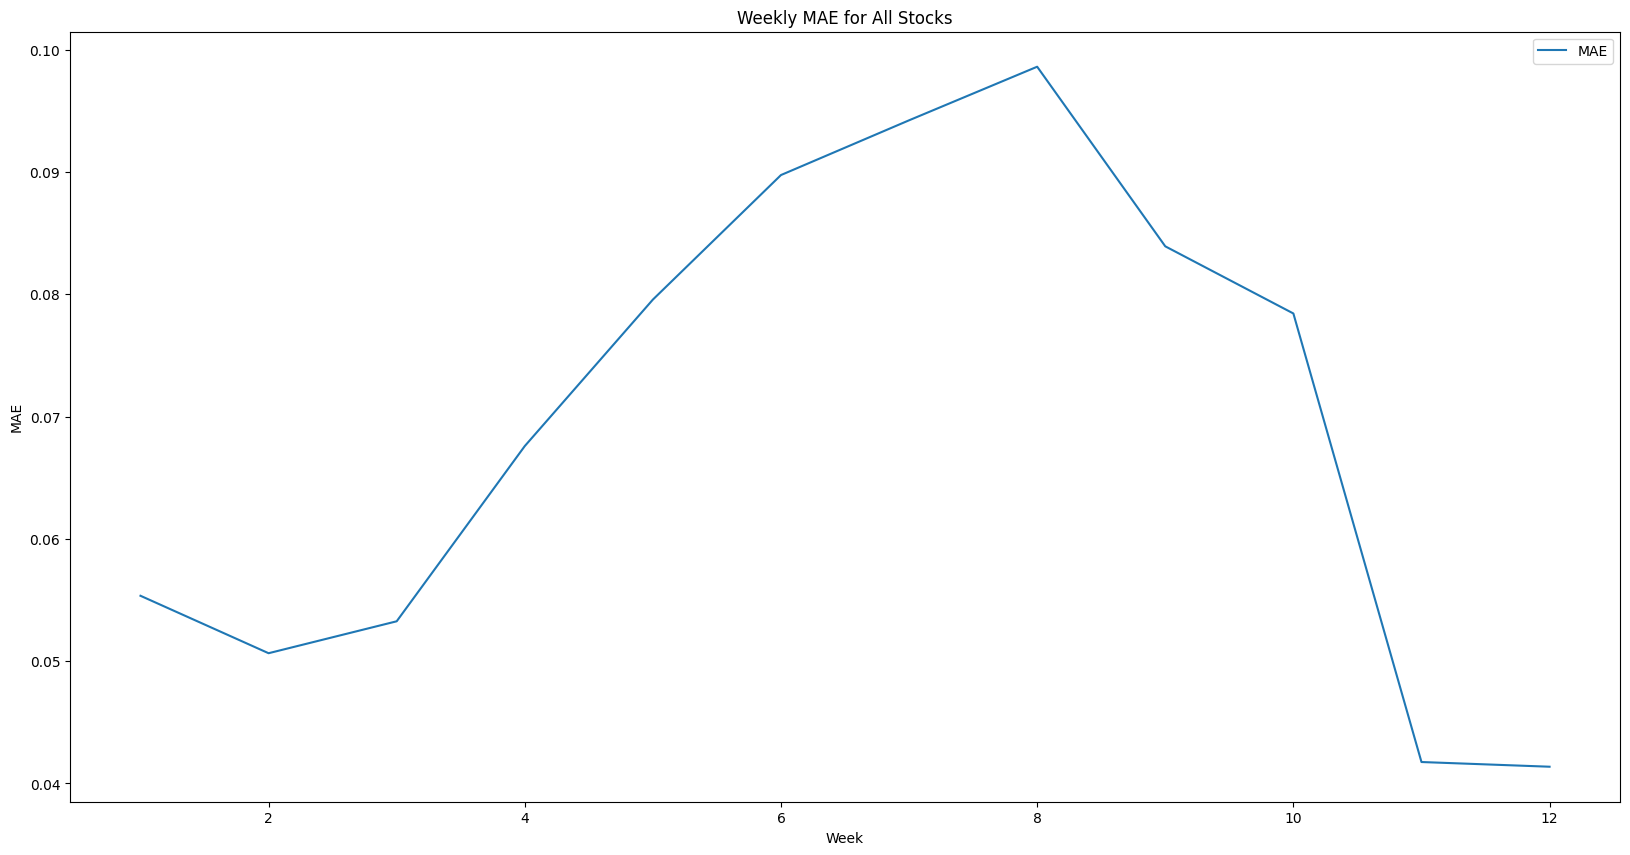

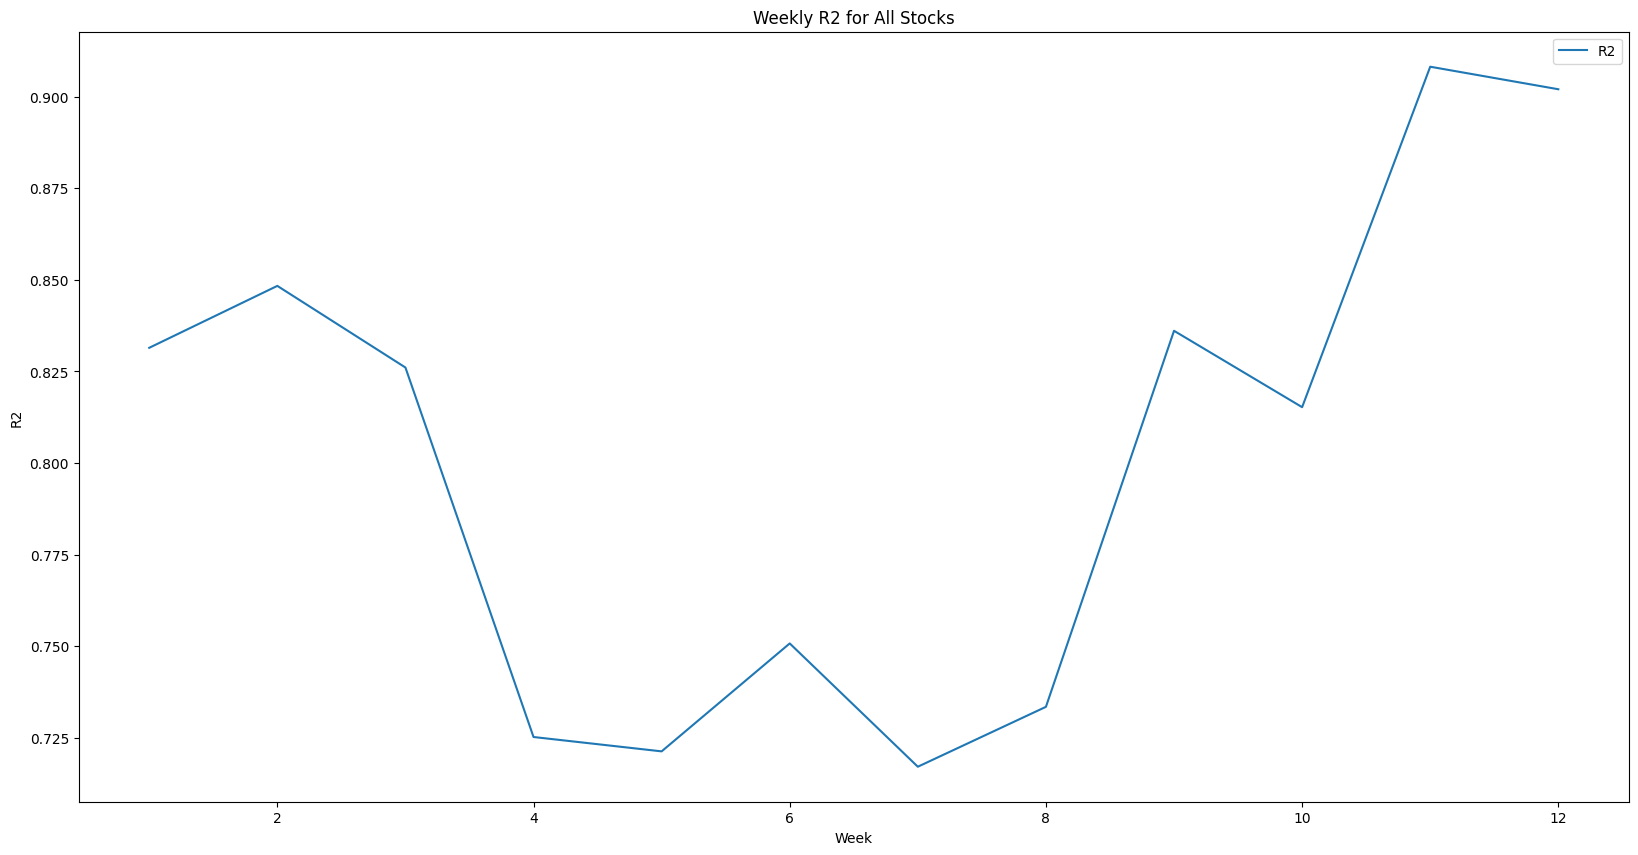

In [142]:
# Plot the weekly metrics for each metric
plt.figure(figsize=(20, 10))
for metric in ['MSE', 'RMSE', 'MAE', 'R2']:
    plt.figure(figsize=(20, 10))
    plt.plot(weekly_metrics_all_pivot['Week'], weekly_metrics_all_pivot[metric], label=metric)
    
    # Add labels and title
    plt.title(f'Weekly {metric} for All Stocks')
    plt.xlabel('Week')
    plt.ylabel(metric)
    plt.legend()
    plt.show()
